In [3]:
import torch
import os

In [4]:
# large model
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')

Using cache found in C:\Users\q42/.cache\torch\hub\facebookresearch_dinov2_main


In [5]:
dinov2_vitl14

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


In [6]:
import requests
from PIL import Image
from torchvision import transforms
# transform = transforms.Compose([           
#                                 transforms.Resize(256),                    
#                                 transforms.CenterCrop(224),               
#                                 transforms.ToTensor(),                    
#                                 transforms.Normalize(                      
#                                 mean=[0.485, 0.456, 0.406],                
#                                 std=[0.229, 0.224, 0.225]              
#                                 )])


transform1 = transforms.Compose([           
                                transforms.Resize(518),
                                transforms.CenterCrop(518), #should be multiple of model patch_size                 
                                transforms.ToTensor(),                    
                                transforms.Normalize(                      
                                mean=[0.485, 0.456, 0.406],                
                                std=[0.229, 0.224, 0.225]              
                                )])

In [7]:
patch_size = dinov2_vitl14.patch_size # patchsize=14 for vitl14
patch_size

#520//14
patch_h  = 520//patch_size
patch_w  = 520//patch_size

# feat_dim = 384 # vits14
# feat_dim = 768 # vitb14
feat_dim = 1024 # vitl14
# feat_dim = 1536 # vitg14

folder_path = "grusch et al/"
total_features  = []
with torch.no_grad():
  for img_path in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img_path)
    img = Image.open(img_path).convert('RGB')
    img_t = transform1(img)
    features_dict = dinov2_vitl14.forward_features(img_t.unsqueeze(0))
    features = features_dict['x_norm_patchtokens']
    total_features.append(features)

total_features = torch.cat(total_features, dim=0)
total_features.shape

torch.Size([2, 1369, 1024])

In [8]:
total_features

tensor([[[-0.2450,  0.4797, -1.5820,  ..., -1.4301,  0.0613, -0.3738],
         [-0.2480,  0.7271, -1.4156,  ..., -1.4918, -0.2936, -0.4542],
         [-0.2408,  0.7405, -1.8452,  ..., -1.1666,  0.4571, -1.1206],
         ...,
         [ 1.8626,  2.5014, -2.7759,  ..., -0.1646,  0.4262, -0.6155],
         [ 1.5640,  2.5264, -2.1892,  ..., -0.3124, -0.3026, -1.2267],
         [ 1.0286,  1.8016, -2.0987,  ...,  0.1338,  0.2365, -1.6332]],

        [[ 0.6248, -1.7636, -0.1343,  ..., -0.6888,  1.0174,  2.1255],
         [ 1.1240, -0.8268, -1.0987,  ..., -0.8974, -1.0288,  1.2799],
         [ 1.4527, -1.0691,  0.5715,  ..., -1.2690,  1.0504, -0.8670],
         ...,
         [ 0.9689,  1.0508, -0.8219,  ..., -0.5057,  0.8072,  0.4459],
         [ 1.0990, -0.7470, -0.3656,  ...,  0.1015, -0.3811,  0.9299],
         [ 1.6436, -1.7748, -0.0816,  ...,  0.3455,  0.4218,  1.3252]]])

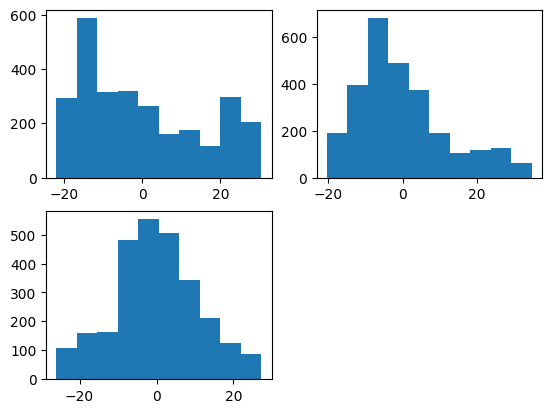

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# First PCA to Seperate Background
# sklearn expects 2d array for training
total_features = total_features.squeeze(0).reshape(-1, 1024)

pca = PCA(n_components=3)
pca.fit(total_features)
pca_features = pca.transform(total_features)

# visualize PCA components for finding a proper threshold
# 4 histograms for 3 components
plt.subplot(2, 2, 1)
plt.hist(pca_features[:, 0])
plt.subplot(2, 2, 2)
plt.hist(pca_features[:, 1])
plt.subplot(2, 2, 3)
plt.hist(pca_features[:, 2])
plt.show()
plt.close()

In [10]:
# Print the shape of pca_features
print("Shape of pca_features:", pca_features.shape)

# Print the slicing indices for each iteration
for i in range(3):
    start_idx = i*patch_h*patch_w
    end_idx = (i+1)*patch_h*patch_w
    print(f"For i={i}, start_idx={start_idx}, end_idx={end_idx}")


Shape of pca_features: (2738, 3)
For i=0, start_idx=0, end_idx=1369
For i=1, start_idx=1369, end_idx=2738
For i=2, start_idx=2738, end_idx=4107


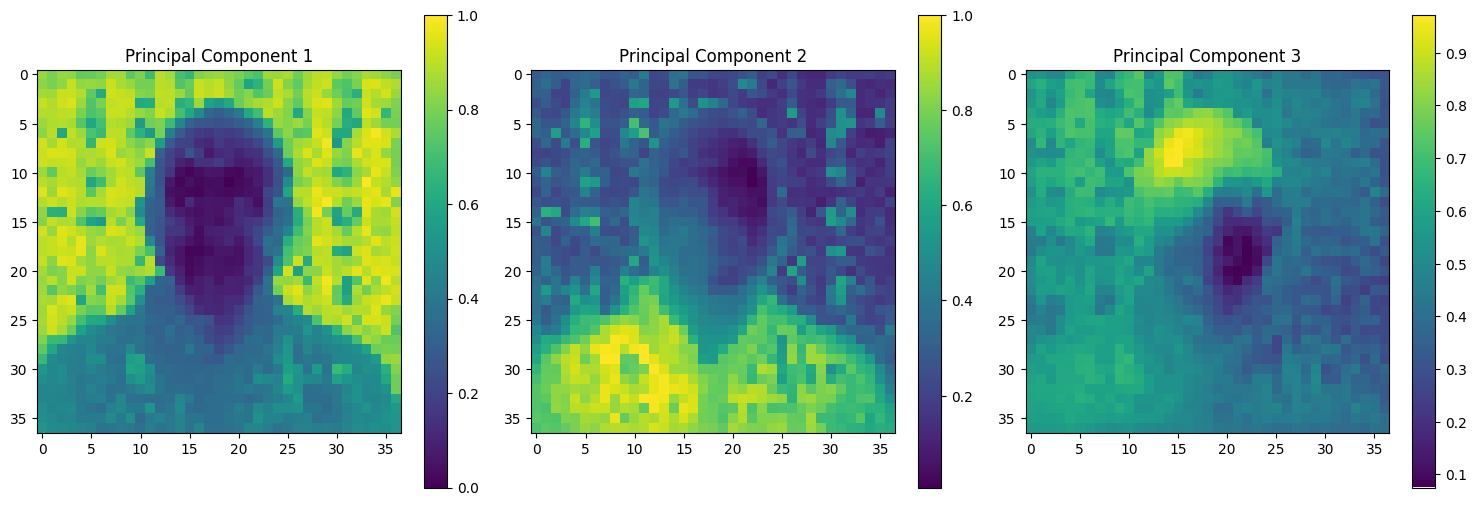

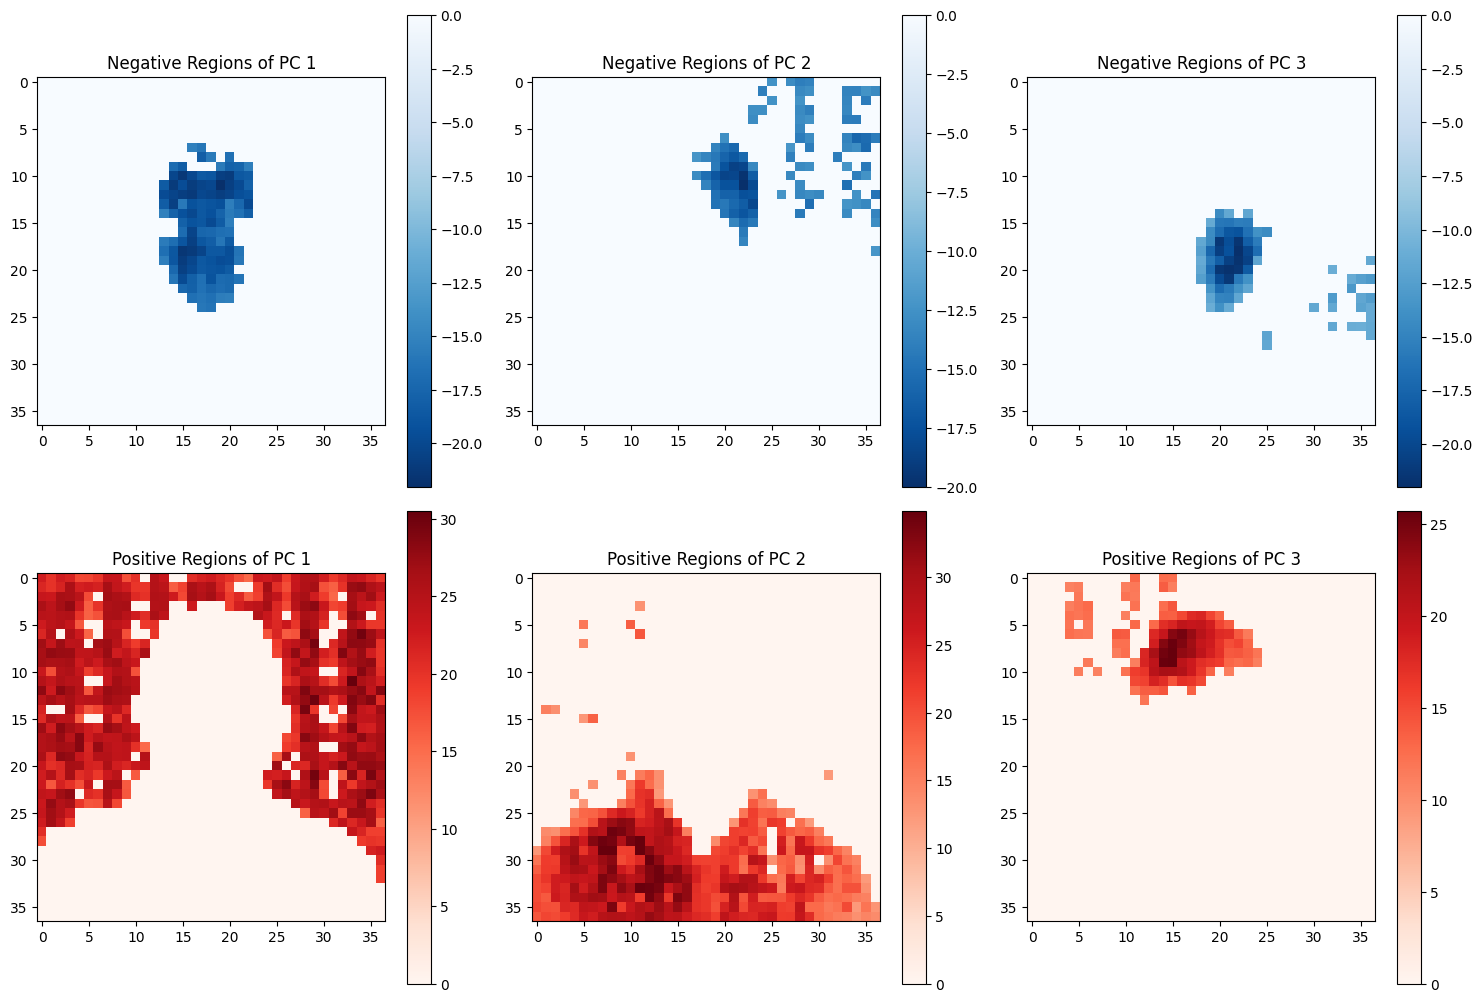

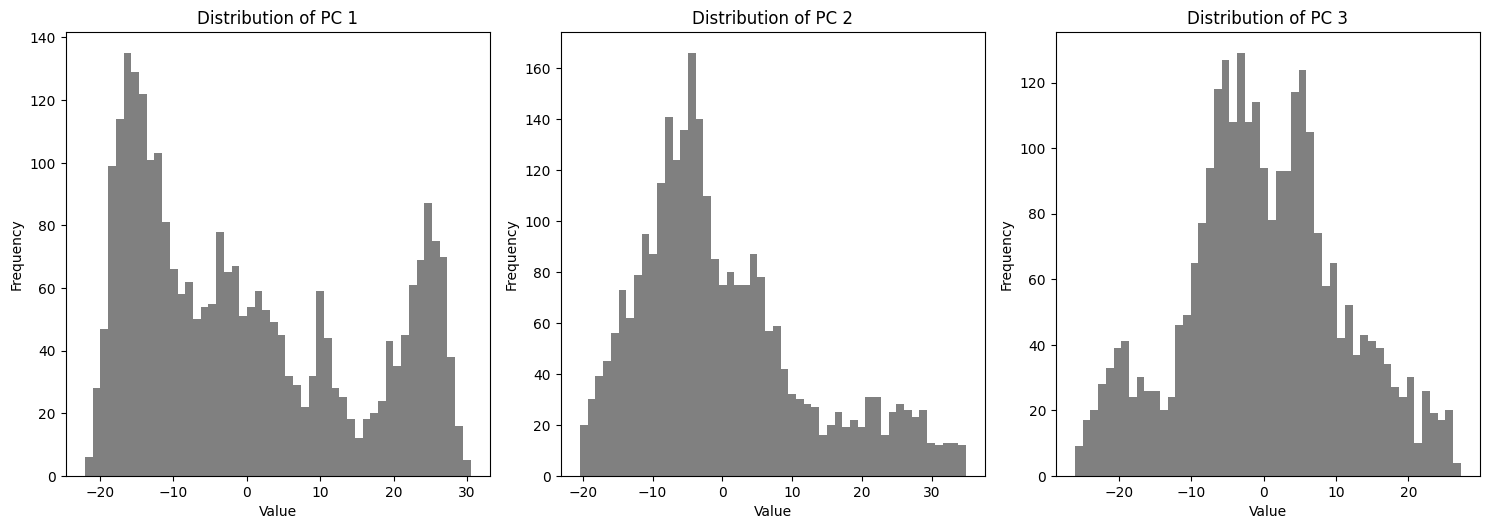

In [11]:
import numpy as np

# Number of principal components to visualize
num_pcs = min(9, pca_features.shape[1])  # Adjust for a 3x3 grid

plt.figure(figsize=(15, 15))

for i in range(num_pcs):
    # Normalize the component for visualization
    component = (pca_features[:, i] - pca_features[:, i].min()) / \
                (pca_features[:, i].max() - pca_features[:, i].min())
    # Display the principal component
    plt.subplot(3, 3, i+1)
    plt.imshow(component[:patch_h*patch_w].reshape(patch_h, patch_w), cmap='viridis')
    plt.title(f"Principal Component {i+1}")
    plt.colorbar()

plt.tight_layout()
plt.show()

# For each component, visualize regions with most negative and positive values
plt.figure(figsize=(15, 15))
for i in range(num_pcs):
    component = pca_features[:, i]
    # Determine threshold for extremes (e.g., values beyond one standard deviation)
    threshold = np.std(component)
    min_component = np.where(component < -threshold, component, 0)
    max_component = np.where(component > threshold, component, 0)
    # Display negative extremes
    plt.subplot(3, 3, i+1)
    plt.imshow(min_component[:patch_h*patch_w].reshape(patch_h, patch_w), cmap='Blues_r')
    plt.title(f"Negative Regions of PC {i+1}")
    plt.colorbar()
    # Display positive extremes
    plt.subplot(3, 3, i+1 + num_pcs)
    plt.imshow(max_component[:patch_h*patch_w].reshape(patch_h, patch_w), cmap='Reds')
    plt.title(f"Positive Regions of PC {i+1}")
    plt.colorbar()

plt.tight_layout()
plt.show()

# Histogram of values for each principal component
plt.figure(figsize=(15, 15))
for i in range(num_pcs):
    plt.subplot(3, 3, i+1)
    plt.hist(pca_features[:, i], bins=50, color='gray')
    plt.title(f"Distribution of PC {i+1}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


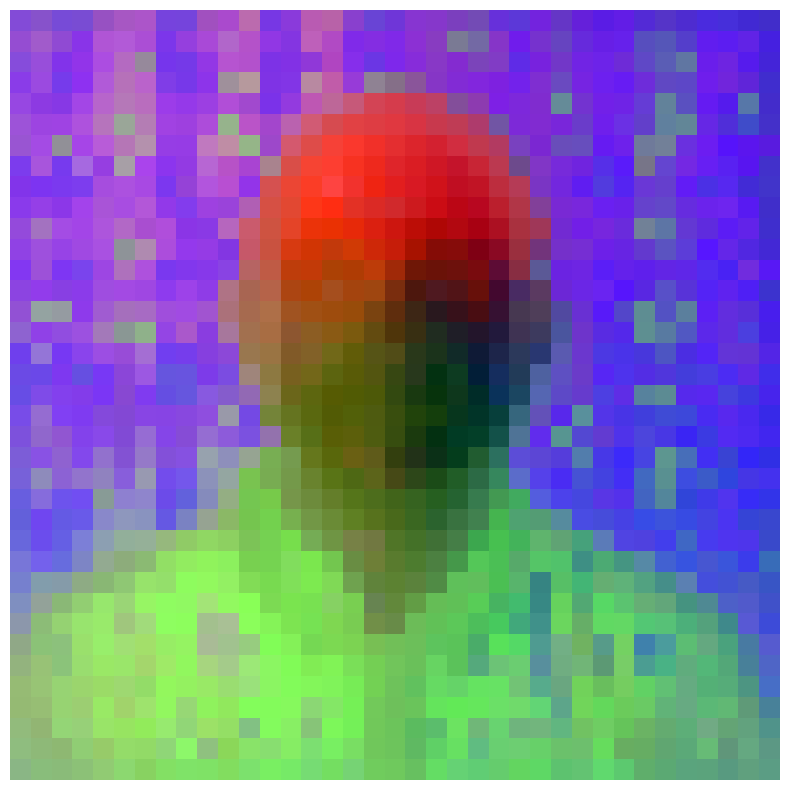

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming pca_features is already defined
# Define a function to normalize an array
def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

# Number of principal components to visualize
num_pcs = min(3, pca_features.shape[1])  # Adjust for the RGB channels

# Create an empty image with 3 channels (RGB)
combined_image = np.zeros((patch_h, patch_w, 3))

# Normalize and assign the principal components to the RGB channels
for i in range(num_pcs):
    component = normalize(pca_features[:, i][:patch_h*patch_w].reshape(patch_h, patch_w))
    
    if i == 0:
        combined_image[:,:,2] = component  # Assign to blue channel
    elif i == 1:
        combined_image[:,:,1] = component  # Assign to green channel
    else:
        combined_image[:,:,0] = component  # Assign to red (for pinkish representation) channel

# Plot the combined image
plt.figure(figsize=(10, 10))
plt.imshow(combined_image)
plt.axis('off')
plt.show()


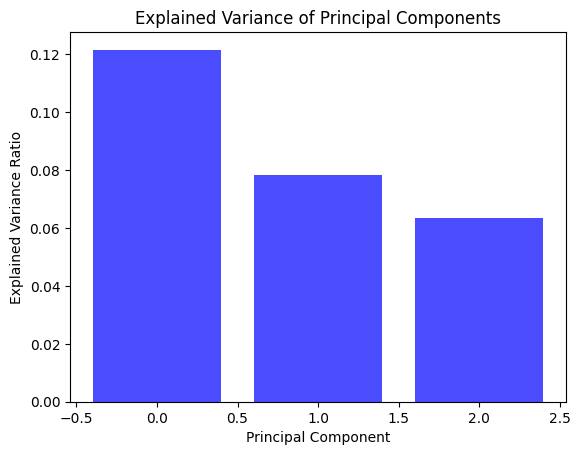

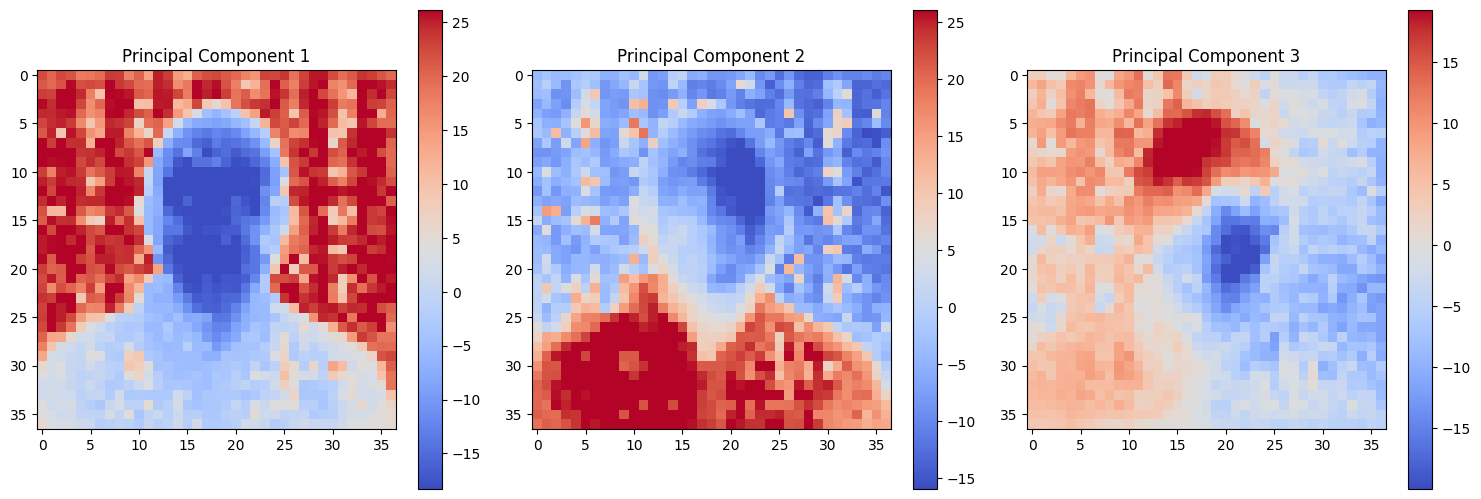

In [10]:
import numpy as np

# Number of principal components to visualize
num_pcs = min(9, pca_features.shape[1])  # Adjust for a 3x3 grid

# Explained Variance
explained_variance = pca.explained_variance_ratio_
plt.bar(range(len(explained_variance)), explained_variance, alpha=0.7, color='blue')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance of Principal Components')
plt.show()

# Heatmap Visualization of PCA components
plt.figure(figsize=(15, 15))
for i in range(num_pcs):
    component = pca_features[:, i]
    min_val, max_val = np.percentile(component, [5, 95])  # Use percentiles for robust range
    plt.subplot(3, 3, i+1)
    plt.imshow(component[:patch_h*patch_w].reshape(patch_h, patch_w), cmap='coolwarm', vmin=min_val, vmax=max_val)
    plt.title(f"Principal Component {i+1}")
    plt.colorbar()

plt.tight_layout()
plt.show()


C:\Users\q42\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


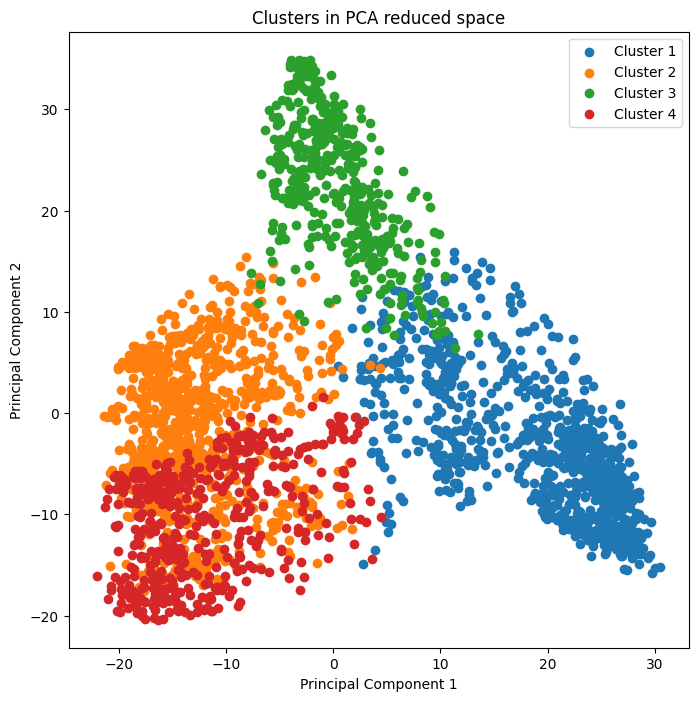

In [28]:
from sklearn.cluster import KMeans

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters).fit(pca_features)
labels = kmeans.labels_

# Visualize clusters for the first two principal components
plt.figure(figsize=(8, 8))
for i in range(n_clusters):
    plt.scatter(pca_features[labels == i, 0], pca_features[labels == i, 1], label=f'Cluster {i+1}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.title('Clusters in PCA reduced space')
plt.show()


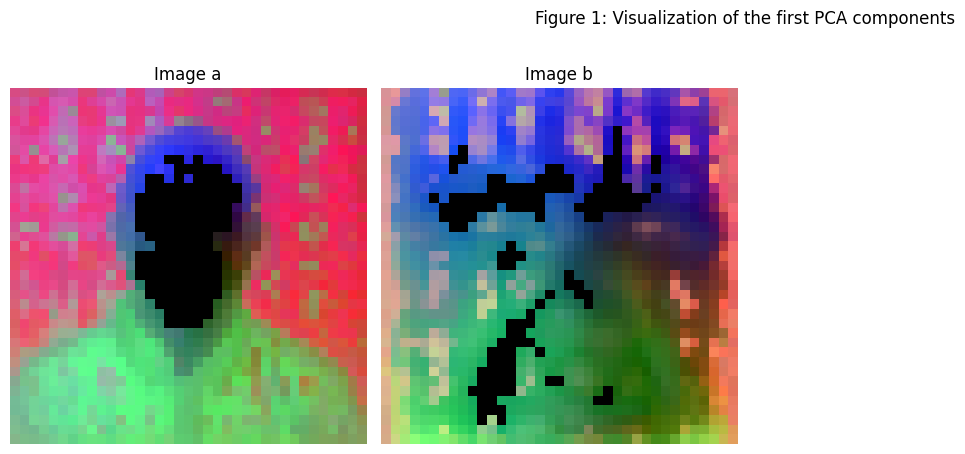

In [29]:
import numpy as np

# Compute PCA and extract the first 3 components
num_pcs = min(3, pca_features.shape[1])

# Visualization of the first 3 PCA components
plt.figure(figsize=(15, 5))
for idx, image_idx in enumerate(range(0, pca_features.shape[0], patch_h*patch_w)):
    combined_image = np.zeros((patch_h, patch_w, 3))
    for channel in range(num_pcs):
        component = pca_features[image_idx:image_idx+patch_h*patch_w, channel]
        normalized_component = (component - component.min()) / (component.max() - component.min())
        combined_image[:, :, channel] = normalized_component.reshape(patch_h, patch_w)
    
    # Remove background by thresholding the first PCA component
    threshold = np.percentile(pca_features[image_idx:image_idx+patch_h*patch_w, 0], 10)
    mask = pca_features[image_idx:image_idx+patch_h*patch_w, 0] > threshold
    combined_image[~mask.reshape(patch_h, patch_w), :] = 0
    
    plt.subplot(1, 4, idx+1)
    plt.imshow(combined_image)
    plt.title(f"Image {chr(97 + idx)}")  # chr(97) corresponds to 'a'
    plt.axis('off')

plt.suptitle("Figure 1: Visualization of the first PCA components")
plt.tight_layout()
plt.show()
